# <p style='text-align: center;'>MA5851 Assessment 3 - Webcrawler and NLP System </p>
# <p style='text-align: center;'>Document 2 - Webcrawlers</p>
### Author - Mathew Holden  
### Student No. - jc759971  

In [121]:
#package dependencies.
from selenium.webdriver import Chrome
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import pandas as pd
import time
import re
from tqdm import tqdm
from bs4 import BeautifulSoup as Soup
from numpy.core.numeric import NaN
import numpy as np
import os
import glob
import pickle
import matplotlib.pyplot as plt
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to C:\Users\Windows
[nltk_data]     7\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Introduction
<font size="4">Two webcrawlers were developed as part of the prototype solution to measure the general sentiment towards Oscar nominated movies and predict a best picture winner. A basic overview is shown below.

<img src="Webcrawler.png">

Webcrawler 1 scrapes data off the https://www.oscars.org/oscars/ceremonies website. Webcrawler 2 scrapes data off the https://www.imdb.com/ website.

Both webcralwers are built using the Selenium package and the chrome webdriver. It is a critical step when using Selenium and any webdriver to first download the webdriver to a known directory and then assign the path to the webdriver using command line and the entry 'setx PATH "%PATH%;C:\path_to_webdriver"' for Windows or 'export PATH=$PATH:/opt/path_to_webdriver >> ~/.profile' in a terminal for MacOS or linux. For more information on setting up webdrivers (not just chrome) for selenium refer to https://www.selenium.dev/documentation/getting_started/installing_browser_drivers/.

Google Chrome Version 96.0.4664.45 (Official Build) (64-bit) was used during development of this prototype code, with Python version 3.7.1 on a Windows 7 machine with intel i5-6300U 2.4GHz CPU and 8GB of RAM.

### Website details
<font size="4">Oscars.org contains a full database of all academy award winners. One of the tasks of the prototype is attempting to predict the best picture winner, so obtaining the correct list of best picture nominees and winners was critical. The url https://www.oscars.org/oscars/ceremonies/#### was scraped, where #### is each year of interest and a list of best picture nominees and winner was returned, as well as the date of the Oscars ceremony for the year. This data is freely available on many other domains such as wikipedia and also imdb.com. Oscars.org was chosen as the most likely to be correct, and for it's ease of scraping as all information required was on a single link. The webcrawler can be easily adapted to scrape other Oscar categories.  

Oscars.org has specific terms and conditions restricting the use of robots to copy site contents. The webcrawler used is for non-commercial, educational research purposes so therefore does not require express permission from the copyright holder. Express consent would need to be sought to use this webcrawler for commercial purposes.  

Imdb.com contains a multitude of information mainly relating to movies and television programs. Users are able to use imdb.com as a search engine for these forms of entertainment as well as provide their own reviews and ratings if they are a registered user. It is the user provided review data that is of interest and is the goal of the webcrawler to traverse to the users review page for each movie provided. The rating out of 10 provided by the user and the date the review was submitted is also recorded for each review entry.

imdb.com has specific terms and conditions restricting the use of robots to copy site contents. The webcrawler used is for non-commercial, educational research purposes so therefore does not require express permission from the copyright holder. Imdb have a developers portal and several API's available through AWS marketplace. These options may be suitable if this prototype was to be scaled and used for commercial purposes.

### Webcrawler 1 - OscarsCrawler
<font size="4">OscarsCrawler webcrawler was built using the python Selenium package and the Chrome webdriver. All code is below.

OscarsCrawler is a class object, with several functions defined. To initiate OscarsCrawler a simple function, get_best\_pictures, runs through a list of provided years and provides url https://www.oscars.org/oscars/ceremonies/ and each year to OscarsCrawler. In the OscarsCrawler \_\_init\_\_ function the year is suffixed to the url and saved as 'link_to_explore' and a movie_list dataframe is created. When the OscarsCrawler run function is called the webdriver is instructed to 'get' the 'link_to_explore' url. An implicit wait of 10 seconds is started as the oscars.org/robot.txt suggests there is a crawl delay. https://www.oscars.org/oscars/ceremonies/ is very structured which made scraping specific information straight forward. Each awards category is contained in a div element with class='view-grouping'. It was simply a matter of finding the class='view-grouping' element with child element h2 with text='BEST PICTURE'. Once in the correct element, each movie title was available as text in each of the h4 elements. The first movie in the list was always the winner so it was identified as such. The date of the ceremony was identified by class='views-field views-field-field-date'. The year, date of the ceremony, movie title and a True or False based on if the movie title won best picture are saved into the movie_list dataframe for each movie found in the best picture element.

The movie_list dataframe is saved as a csv file to the working directory for each call of OscarsCrawler. The csv filename is the year scraped prefixed onto '\_movies.csv'. A file is saved every iteration in case there is a connectivity issue during the web crawl, so all the previous data is captured.</font>

In [6]:
class OscarsCrawler(): 
    """OscarsCrawler will take input url 'https://www.oscars.org/oscars/ceremonies/' for start_link
    and a year as text for year_to_crawl.
    The crawler finds the Best Picture category and grabs the movie that won and the other nominees.
    The return is a dataframe with columns 'Year' (year of oscars), 'Date' (the date of the oscars
    ceremony), 'Title' (each movie title) and 'Winner' (True for the winner).
    Could be adapted for other oscar categories by changing the h2 tag compare text in the extract
    data function, or even adding other categories.
    Dependencies -  from selenium.webdriver import Chrome
                    from selenium import webdriver
                    from selenium.webdriver.common.by import By
                    import pandas as pd
    """
    def __init__(self, start_link, year_to_crawl):
        self.link_to_explore = start_link + str(year_to_crawl)
        self.year_to_crawl = year_to_crawl
        self.movie_list = pd.DataFrame(columns = ['Year','Date','Title','Winner'])
        self.driver = Chrome()            
        self.pagecount = 0
        self.next = True
    
    def run(self):
        while self.next:
            try:
                self.driver.get(self.link_to_explore)
                self.driver.implicitly_wait(10)
                self.extract_data()
                self.next = False
            except:
                print ("Cannot get the page " + self.link_to_explore)
                self.next = False
                raise
        self.save_data_to_file()
        return self.movie_list
                
    def extract_data(self):
        all_cats = self.driver.find_elements_by_xpath("//*[@class='view-grouping']")
        ceremony_date = self.driver.find_element_by_xpath("//div[@class='views-field views-field-field-date']").text
        try:
            for each in all_cats:
                if each.find_element(By.TAG_NAME, "h2").text == 'BEST PICTURE':
                    movies = each.find_elements(By.TAG_NAME, "h4")
                    Winner = True
                    for movie in movies:
                        self.movie_list.loc[len(self.movie_list)] = [self.year_to_crawl,ceremony_date,
                                                                    movie.text,Winner]
                        Winner = False
        except:
            pass 

    def save_data_to_file(self):
    #we save the dataframe content to a CSV file
        file_name = str(self.year_to_crawl) + '_movies.csv'
        self.movie_list.to_csv(file_name, index = None, header=True)
    def close_spider(self):
    #end the session
        self.driver.quit()

def get_best_pictures(start_year,end_year):
    """Given a start and end year, webscrape the Oscars website and return
    the best picture winner and nominees for each year.
    Return is designed to be fed into get_movie_reviews"""
    for input_year in range(start_year,end_year+1):
        try:
            url = 'https://www.oscars.org/oscars/ceremonies/'
            mycrawler = OscarsCrawler(url,input_year)
            movie_list = mycrawler.run()
            mycrawler.close_spider()
        except:
            raise
    return movie_list

### OscarsWebcrawler - Extract Data
<font size="4">The code block below extracts the movie data with the OscarsCrawler. It sends the start year and end year to the get_best_pictures function which is described above.</font>

In [ ]:
#Send start year and end year into get_best_pictures and then retrieve reviews
best_picture_to_reviews(2015,2021)

### Webcrawler 2 - ImdbCrawler
<font size="4">ImdbCrawler webcrawler was built using the python Selenium package and the Chrome webdriver. All code is available at the bottom of this markdown document.

ImdbCrawler is a class object, with several functions defined. To initiate ImdbCrawler a simple function, get_movie\_reviews, runs through a list of movie titles and years and initialises ImdbCrawler with url https://www.imdb.com/, movie title and year. The webdriver is instructed to 'get' that url. In the ImdbCrawler \_\_init\_\_ function the url and saved as 'link_to_explore', the movie title is set as search_string variable and a comments dataframe is created. When the ImdbCrawler run function is called the webdriver is instructed to 'get' the 'link_to_explore' url. To find the reviews for the intended movie the search_string has to be entered into the search bar, the send_keys method is used to achieve that. The search_string is appended with \n to mimic a user pressing enter after entering the search string. The next page to get loaded in the webdriver contains lists of possible matches to the search string. Generally the first entry should be the movie of interest. However, there are many movies with the same name so a check that the year associated with the title is within 1 or 2 years of our required movie is required. Note the year we have at this point is the Oscars ceremony year, so the movie will normally be the previous year. It is possible for movies to be released 2 calendar years before being nominated for an Oscar. Each td element with class='result_text' is iterated through checking for text containing the year. If a valid a element with a href containing 'title' is found then the click() command is used to select the link. If no valid link is found then the crawler is exited and a dataframe with only the name of the movie is returned.  

After selecting the correct movie link there is a standard a element with href containing '/reviews' that is the link to the user reviews page which is selected with the click() command. By default there are only 25 reviews visible on the user reviews page. There is a 'Load more button' that will load in the next 25 reviews. Once all the reviews are visible this button disappears. The selenium package contains functions that will explicitly wait until an element is in a particular state. After each click of the 'Load more button' an explicit wait is used to delay the code until the 'Load more button' is clickable again. By wrapping this click-wait routine in a try,except and wrapping that in a while True loop the button will be clicked repeatedly until it disappears and the except passes the code out.  

Extracting the data requires iterating through each of the div elements with class="review-container". Inside each of these elements the review date and the user rating is extracted from the text of elements with class="review-date" and class="rating-other-user-rating") respectively. Not every user leaves a rating, so extracting the rating text is wrapped in a try, except function. The actual review text is contained in an element with class="content". Imdb has a feature that will hide review text if they could contain movie spoilers. Selenium will only interact with the visible elements, but as the text was still available in the html the Beautiful Soup package was utilised to get the text from that element. The movie title, Review date, User Rating and review text comments dataframe for each review found.  

The comments dataframe is saved as a csv file to the working directory for each call of ImdbCrawler. The csv filename is the year and movie title prefixed onto "\_reviews.csv". Regular expressions are used to remove all special characters from the movie title and it is restricted to 10 characters before using as a filename. Special characters in filenames can cause operating system errors.  A file is saved every iteration in case there is a connectivity issue during the web crawl, so all the previous data is captured.

In [124]:
class ImdbCrawler(): 
    """ImdbCrawler will take input url 'https://www.imdb.com/' for start_link, a movie title
    for search_string and a year the movie was released for year_release. year_release MUST be an 
    integer!!
    The crawler searches the Imdb site for the movie and steps through to user reviews. All reviews
    are shown by pressing the load more button until it is removed.
    The return is a dataframe with columns 'Movie' (the movie searched), 'Date' (review date),
    'Rating' (review rating) and 'Comments' (Review text).
    Note some Ratings are blank and some Comments will be blank.
    Dependencies -  from selenium.webdriver import Chrome
                    from selenium import webdriver
                    from selenium.webdriver.common.keys import Keys
                    from selenium.webdriver.common.by import By
                    from selenium.webdriver.support.ui import WebDriverWait
                    from selenium.webdriver.support import expected_conditions as EC
                    import pandas as pd
    """
    def __init__(self, start_link, search_string, year_release):
        self.link_to_explore = start_link 
        self.comments = pd.DataFrame(columns = ['Title','Date','Rating','Comments'])
        self.search_string = search_string
        self.year_release = year_release
        self.driver = Chrome()            
        self.pagecount = 0
        self.next = True
                
    def run(self):
        while self.next:
            try:
                self.driver.get(self.link_to_explore)
                search_input = self.driver.find_element_by_xpath("//input[@type='text']")
                search_input.send_keys(self.search_string + '\n')
                results = self.driver.find_elements_by_xpath("//td[@class='result_text']")
                link_flag = True
                try:
                    for each in results:
                        if (str(self.year_release) in each.text) or (str(self.year_release-1) in each.text):
                            link = each.find_element_by_xpath("./a[contains(@href,'title')]")
                            link_flag = False
                            break
                    if link_flag:
                        for each in results:
                            if str(self.year_release-2) in each.text:
                                link = each.find_element_by_xpath("./a[contains(@href,'title')]")
                                link_flag = False
                                break
                    if link_flag:
                        self.comments.loc[0] = [self.search_string,'','',''] 
                        return self.comments
                    else:
                        link.click()
                        self.driver.find_element_by_xpath("//a[contains(@href,'/reviews')]").click()
                except:
                    self.comments.loc[0] = [self.search_string,'','',''] 
                    return self.comments
                #load all reviews in, click load more and wait until it appears again.
                while True:
                    try:
                        self.driver.find_element_by_xpath("//button[contains(@class,'ipl-load-more__button')]").click()
                        wait = WebDriverWait(self.driver, 10, poll_frequency=1)
                        element = wait.until(EC.element_to_be_clickable((By.XPATH, "//button[contains(@class,'ipl-load-more__button')]")))
                    except:
                        break 
                self.extract_data()
                self.next = False
            except:
                print ("Cannot get the page " + self.link_to_explore)
                self.next = False
                raise
        self.save_data_to_file()
        return self.comments
                                
    def extract_data(self):
        reviews = self.driver.find_elements_by_xpath("//div[@class='review-container']")
        
        for review in reviews:
            review_date = review.find_element(By.CLASS_NAME, "review-date")
            try:
                rating = review.find_element(By.CLASS_NAME,"rating-other-user-rating").text
            except:
                rating = ""
                pass            
            review_text = review.find_element(By.CLASS_NAME,"content")
            #need to extract HTML to see hidden text
            soup = Soup(review_text.get_attribute('innerHTML'), 'html.parser')
            #To look at the HTML underlying to the web 
            review_text = soup.find('div').text
            self.comments.loc[len(self.comments)] = [self.search_string,review_date.text,
                                                    rating,review_text]       

    def save_data_to_file(self):
    #we save the dataframe content to a CSV file, useful if something goes wrong during a 
    #long multiple call crawl
        #need to clean up the movie title to remove special characters
        regex = re.compile('[^a-zA-Z0-9 ]')
        file_name_title = regex.sub('', self.search_string)
        file_name = str(self.year_release) + "_" + file_name_title[0:10] + "_reviews.csv"
        self.comments.to_csv (file_name, index = None, header=True)
    def close_spider(self):
    #end the session
        self.driver.quit()
        
def get_movie_reviews(movie_list):
    """Given a dataframe of movie titles and year of interest webscrape
    the Imdb website and obtain a .csv file for all reviews."""
    for row in range(len(movie_list)):
        try:
            movie_title = movie_list.iloc[row]['Title']
            year_released = movie_list.iloc[row]['Year']
            #print to keep track of where crawler is
            print(movie_title, year_released)
            #run imdb_crawl with movie and year
            #take the movie title and get the reviews
            url = 'https://www.imdb.com/'
            mycrawler = ImdbCrawler(url,movie_title,int(year_released))
            mycrawler.run()
            mycrawler.close_spider()
        except:
            print("Get reviews for {},{} failed!".format(movie_title,year_released))
            raise

### ImdbWebcrawler - Extract Data
<font size="4">There are two code blocks supplied for extracting review data with the ImdbCrawler. The first will find all csv files that contain '_movies.csv' in the working directory and one by one initiate the ImdbCrawler with a dataframe read from the csv file. In practice this can take many hours and any connection errors will stop the process. The output will tell the user which movie the code failed at. The second block allows the user to enter just one specific csv file, for example '2020_movies.csv'. This will then extract review data only for that single list of movies.This can take 30-60 minutes but is less prone to interuption from connection errors.</font>

In [ ]:
#use this block of code if you have obtained multiple movie list and they are saved in the working directory
#Note this could take several hours
all_filenames = [i for i in glob.glob('*_movies.csv')]
for filename in all_filenames:
    movie_list = pd.read_csv(filename)
    get_movie_reviews(movie_list)

In [125]:
#use this block of code to grab an individual movies.csv file to run, this can take 30 minutes to an hour
#Or manually assign a movie and year to the variables. Useful if connection was interupted midway through imdb review scrape
def movie_reviews(movies,years):
    if (len(movies) > 0) & (len(movies) == len(years)):
        movie_list = pd.DataFrame(columns = ['Year','Title'])
        for i in range(len(movies)):
            year = years[i]
            movie = movies[i]
            movie_list.loc[i] = [year, movie]
        get_movie_reviews(movie_list)
        
#Update these variables if required
movie_list = pd.read_csv("2020_movies.csv")  #change this to the file to use
movies = movie_list["Title"]                 #alternatively ['movie1','movie2']
years = movie_list["Year"]                   #alternatively ['year1','year2']
movie_reviews(movies,years)

PARASITE 2020
FORD V FERRARI 2020
THE IRISHMAN 2020
JOJO RABBIT 2020
JOKER 2020
LITTLE WOMEN 2020
MARRIAGE STORY 2020
1917 2020
ONCE UPON A TIME...IN HOLLYWOOD 2020


### Harvested Corpus Data
<font size="4">Once all required movies and movie reviews have been saved the combine_files() function joins all the movie files together and all the review files together and saves them as pickle files on the working directory. The pickle files are utilised in the NLP model code.

Before saving as pickle files the "Date" column data is converted to datetime format and the "Title" column data is converted to a string. The review files contain user ratings in the form "#/10", where # is the users rating score. A user does not have to leave a rating though, so if a rating exists it is split by the "/" and the user rating is converted to an integer.

Details relating to the raw data extraction for the years 2015 to 2021 are described here:  
Number of Movies queried: 59  
Length of missing comments Df: 1  
Movie titles with comments missing: {'SOUND OF METAL'}  
Total number of reviews: 95014  
Na or Null Data by column:  
Year              0  
Date_oscars       0  
Title             0  
Winner            0  
Date_review       0  
Rating         2393  
Comments          0  

So only 1 movie was not able to be returned from Imdb and 2393 users did not provide a rating. A full breakdown of reviews per movie is shown in figure 1 below.

Statistics for the 95,014 reviews that will form the corpus for NLP are described here:  
Average words per review: 170  
Average words per sentence per review: 21  
Average length of each word: 5  

Cumulative counts of the most frequently occuring words in the first 10,000 reviews are shown at the end of this notebook in figure 2 and 3, both with and without stopwords removed respectively. 'movie' and 'film' are the most frequent words in the corpus when stop words are ignored, which is to be expected.

In [126]:
#run this code to combine all the individual .csv files into 2 pickle files for use in the model notebooks
def combine_files():
    #import all reviews files
    extension = 'csv'
    for name in ['_movies','_reviews']:
        all_filenames = [i for i in glob.glob('*{}.{}'.format(name, extension))]
        if len(all_filenames) > 0:
            #combine all files in the list
            temp_df = pd.concat([pd.read_csv(f) for f in all_filenames],ignore_index = True)
            temp_df = temp_df.drop_duplicates()
            #Set column types
            temp_df["Date"] = [pd.to_datetime(x).date() for x in temp_df["Date"]]
            temp_df["Title"]  = [str(title) for title in temp_df["Title"]]
            if name == '_reviews':
                for i in temp_df.index:
                    if isinstance(temp_df.loc[i]["Rating"],str):
                        temp_rating = str(temp_df.loc[i]["Rating"])
                        temp_df.loc[i]["Rating"] = int(temp_rating.split("/")[0])
            #export to pickle, check if it exists first and concatenate
            filename = ("./all{}.pkl".format(name))
            try:
                exist_df = pd.read_pickle(filename)
                temp_df = pd.concat([exist_df,temp_df],axis = 0,ignore_index=True)
                temp_df = temp_df.drop_duplicates()
            except:
                pass            
            temp_df.to_pickle(filename)
            #[os.remove(f)for f in all_filenames]
            
combine_files()

In [136]:
#EDA and visualisation of extracted data
movies_df = pd.read_pickle("all_movies.pkl")
reviews_df = pd.read_pickle("all_reviews.pkl")
#check for missing movies, join the dataframes
merge_df = pd.merge(movies_df,reviews_df,how="outer", #outer join will keep all values in both datasets
    on='Title',                    #don't have a common key
    left_on=None,           
    right_on=None,
    left_index=False,           #don't need left_index or right_index
    right_index=False,
    sort=False,                 #don't need to sort. Will improve performance
    suffixes=("_oscars", "_review"), #separate common columns names
    copy=True,                  #leave as default
    indicator=False,             #will provide a column 'merge' which will define where the observation came from (both, left or right)
    validate=None,               #don't need to validate
)
print("Number of Movies queried: {}".format(len(set(merge_df["Title"]))))
#we get rid of any rows where we don't have Comments
missing_comments_index = [i for i in merge_df.index if isinstance(merge_df.loc[i]["Comments"],str)]
#we want to see what movie titles don't have comments saved. This should only be those that didn't get a return
#from the imdb webcrawler
missing_df = merge_df.drop(missing_comments_index)
print("Length of missing comments Df: {}".format(len(missing_df)))
print("Movie titles with comments missing: {}".format(set(missing_df["Title"])))
#save a dataframe with only movies with comments
complete_df = merge_df.loc[missing_comments_index]
#print missing data
print("Total number of reviews: {}".format(len(complete_df)))
print("Na or Null Data by column:")
print(complete_df.isna().sum())
print("Column Types:")
for column in complete_df.columns:
    print(column, complete_df[column].dtype.name)  

Number of Movies queried: 59
Length of missing comments Df: 1
Movie titles with comments missing: {'SOUND OF METAL'}
Total number of reviews: 95014
Na or Null Data by column:
Year              0
Date_oscars       0
Title             0
Winner            0
Date_review       0
Rating         2393
Comments          0
dtype: int64
Column Types:
Year int64
Date_oscars object
Title object
Winner bool
Date_review object
Rating object
Comments object


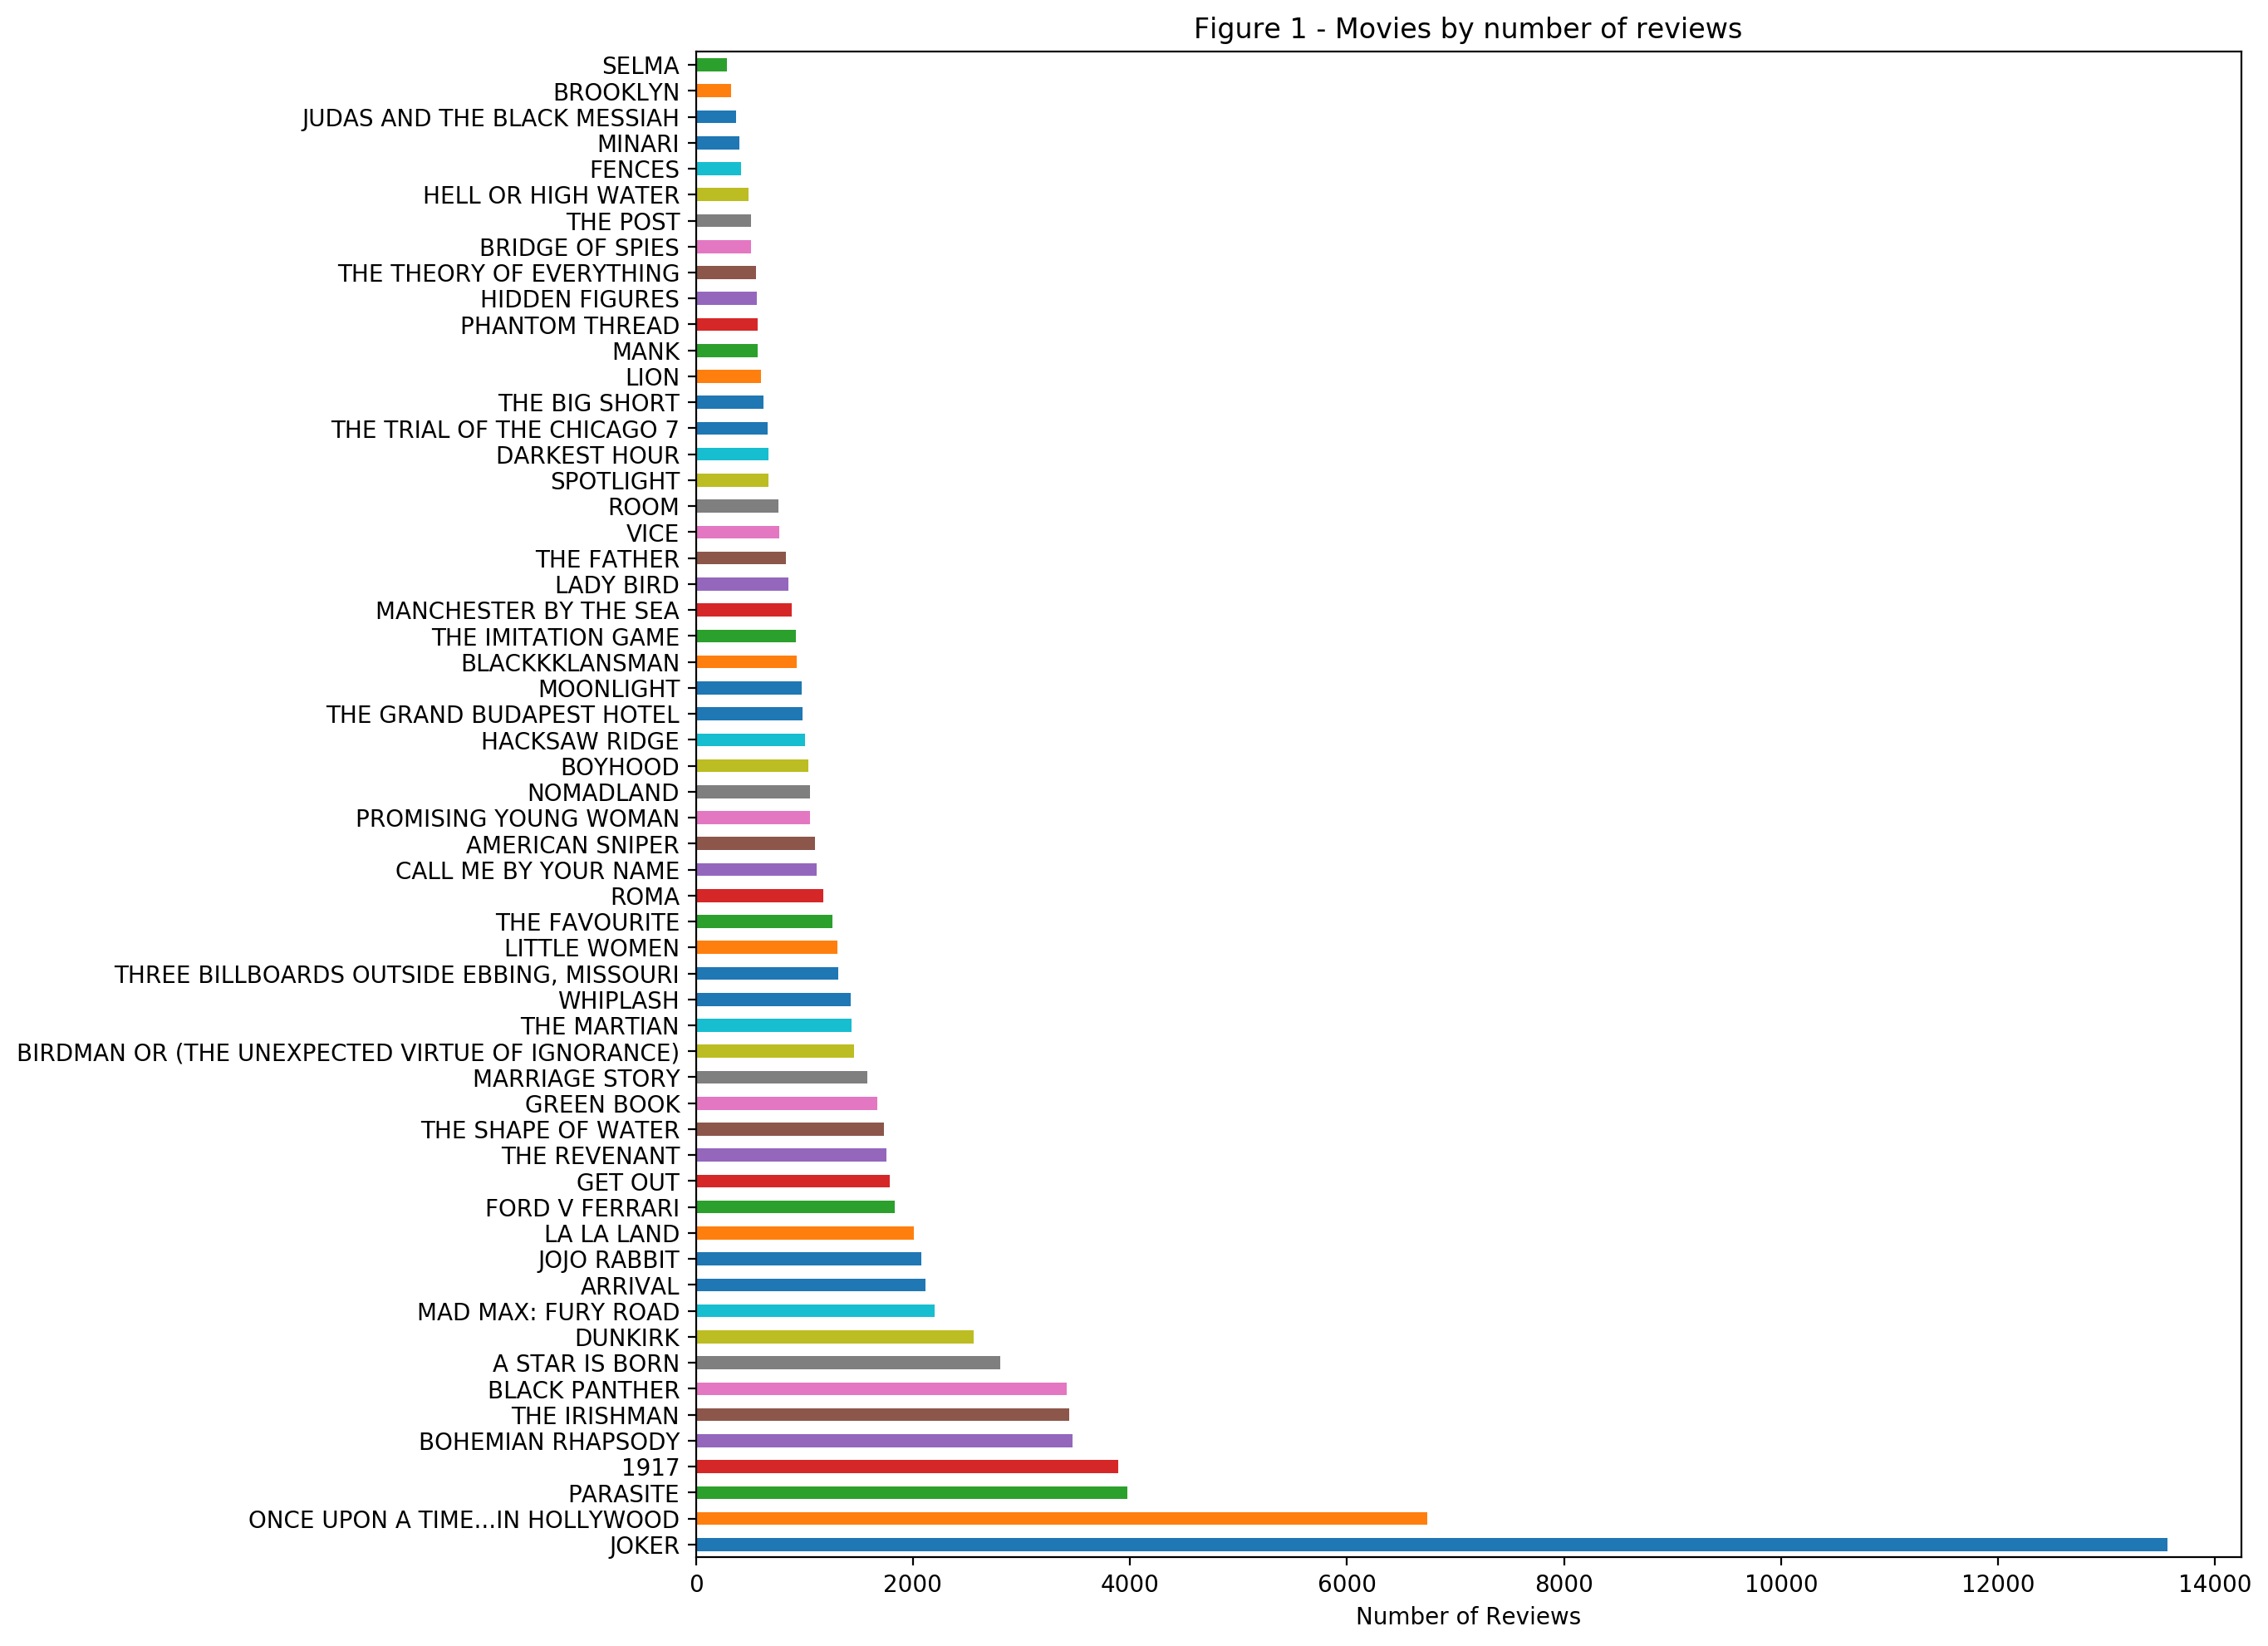

In [128]:
#Visualise the reviews per movie
plt.rcParams['figure.figsize'] = [12, 12]
plt.rcParams['figure.dpi'] = 200
#Visualise reviews per movie
complete_df["Title"].value_counts().plot(kind='barh')
plt.xlabel('Number of Reviews')
plt.title('Figure 1 - Movies by number of reviews')

plt.show()

In [129]:
def extract_features(raw_corpus):
    output_features = pd.DataFrame(columns = ['total_words','words_per_sent','avg_word_len'])
    tokenizer = RegexpTokenizer(r'\w+')
    lemmatizer = WordNetLemmatizer()
    for i in tqdm(raw_corpus.index):
        try:
            sent_text = nltk.sent_tokenize(raw_corpus[i])
        except:
            print(i)
            pass
        tokens = tokenizer.tokenize(raw_corpus[i])
        tokens = nltk.Text(tokens)
        total_words = len(tokens)
        total_sents = len(sent_text)
        if total_words > 0 and total_sents > 0:
            #words per sentence
            words_per_sent = int(total_words/total_sents)
            #average length of words
            avg_word_len = int(len(raw_corpus[i])/total_words)
        else:
            words_per_sent = 0
            avg_word_len = 0
        output_features.loc[len(output_features)] = [total_words,words_per_sent,avg_word_len]
    return output_features

corpus_stats = extract_features(complete_df["Comments"])

100%|██████████| 95014/95014 [07:38<00:00, 207.25it/s]


In [130]:
print("Average words per review: {}".format(int(np.mean(corpus_stats["total_words"]))))
print("Average words per sentence per review: {}".format(int(np.mean(corpus_stats["words_per_sent"]))))
print("Average length of each word: {}".format(int(np.mean(corpus_stats["avg_word_len"]))))

Average words per review: 170
Average words per sentence per review: 21
Average length of each word: 5


In [131]:
#We can visualise some information about the comments corpus
#Note only using 10,000 entries due to processing power
unclean_corpus = complete_df["Comments"][:10000]
corpus = []
for i in unclean_corpus.index:
  review = re.sub('[^a-zA-Z]', ' ',unclean_corpus.loc[i])
  review = review.lower()
  review = review.split()
  corpus.append(review)

In [132]:
corpus_token = ""
for i in corpus:
    corpus_token = corpus_token + " " + " ".join([word for word in i])

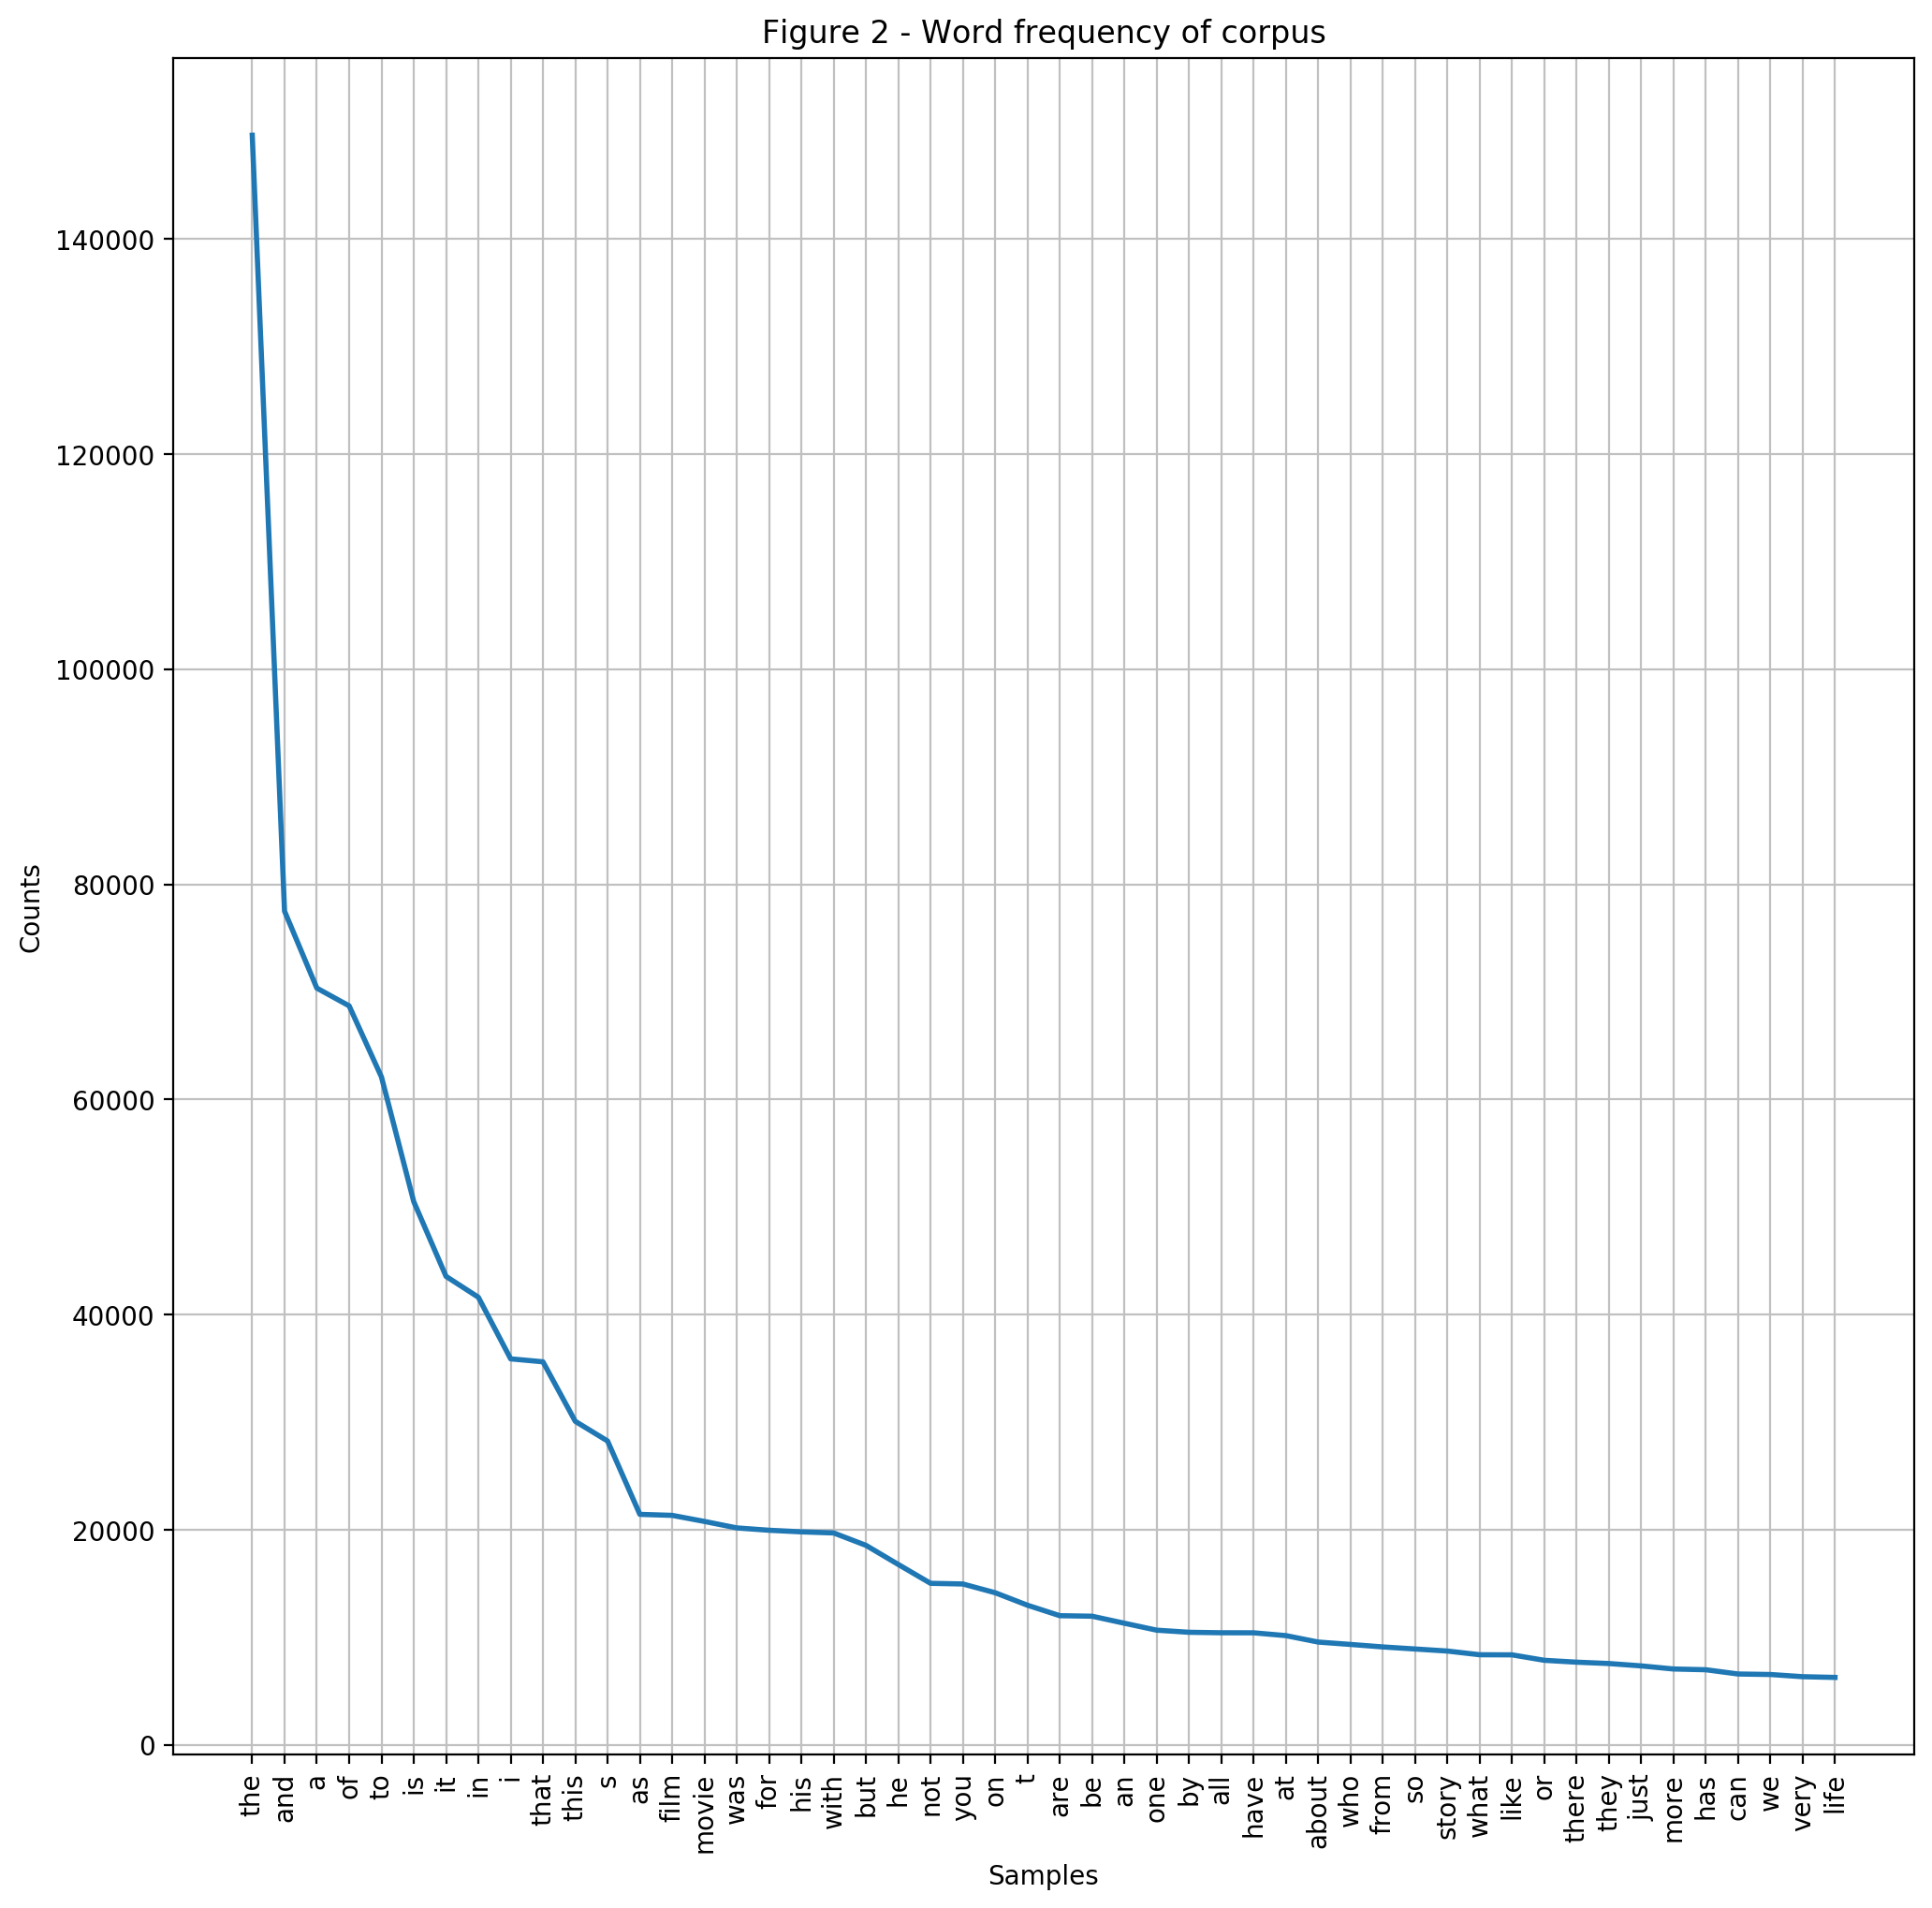

[('the', 149632), ('and', 77504), ('a', 70349), ('of', 68699), ('to', 62095), ('is', 50501), ('it', 43553), ('in', 41614), ('i', 35887), ('that', 35613), ('this', 30081), ('s', 28251), ('as', 21432), ('film', 21338), ('movie', 20772), ('was', 20172), ('for', 19954), ('his', 19805), ('with', 19703), ('but', 18550)]
['marcello', 'mastroianni', 'placements', 'buzzes', 'vindictiveness', 'smiliar', 'sils', 'squawking', 'sharpening', 'soccer', 'ou', 'inesperada', 'virtude', 'ignor', 'ncia', 'sayings', 'lycra', 'apropos', 'maguffins', 'malden']


In [141]:
corpus = nltk.word_tokenize(corpus_token)
freqdist = nltk.FreqDist(corpus)
freqdist.plot(50, cumulative=False, title='Figure 2 - Word frequency of corpus')
#20 most common words
print(freqdist.most_common(20))
#hapaxes are the least frequent words
print(freqdist.hapaxes()[:20])

In [ ]:
corpus_no_sw = [word for word in corpus if not word in stopwords.words('english')]

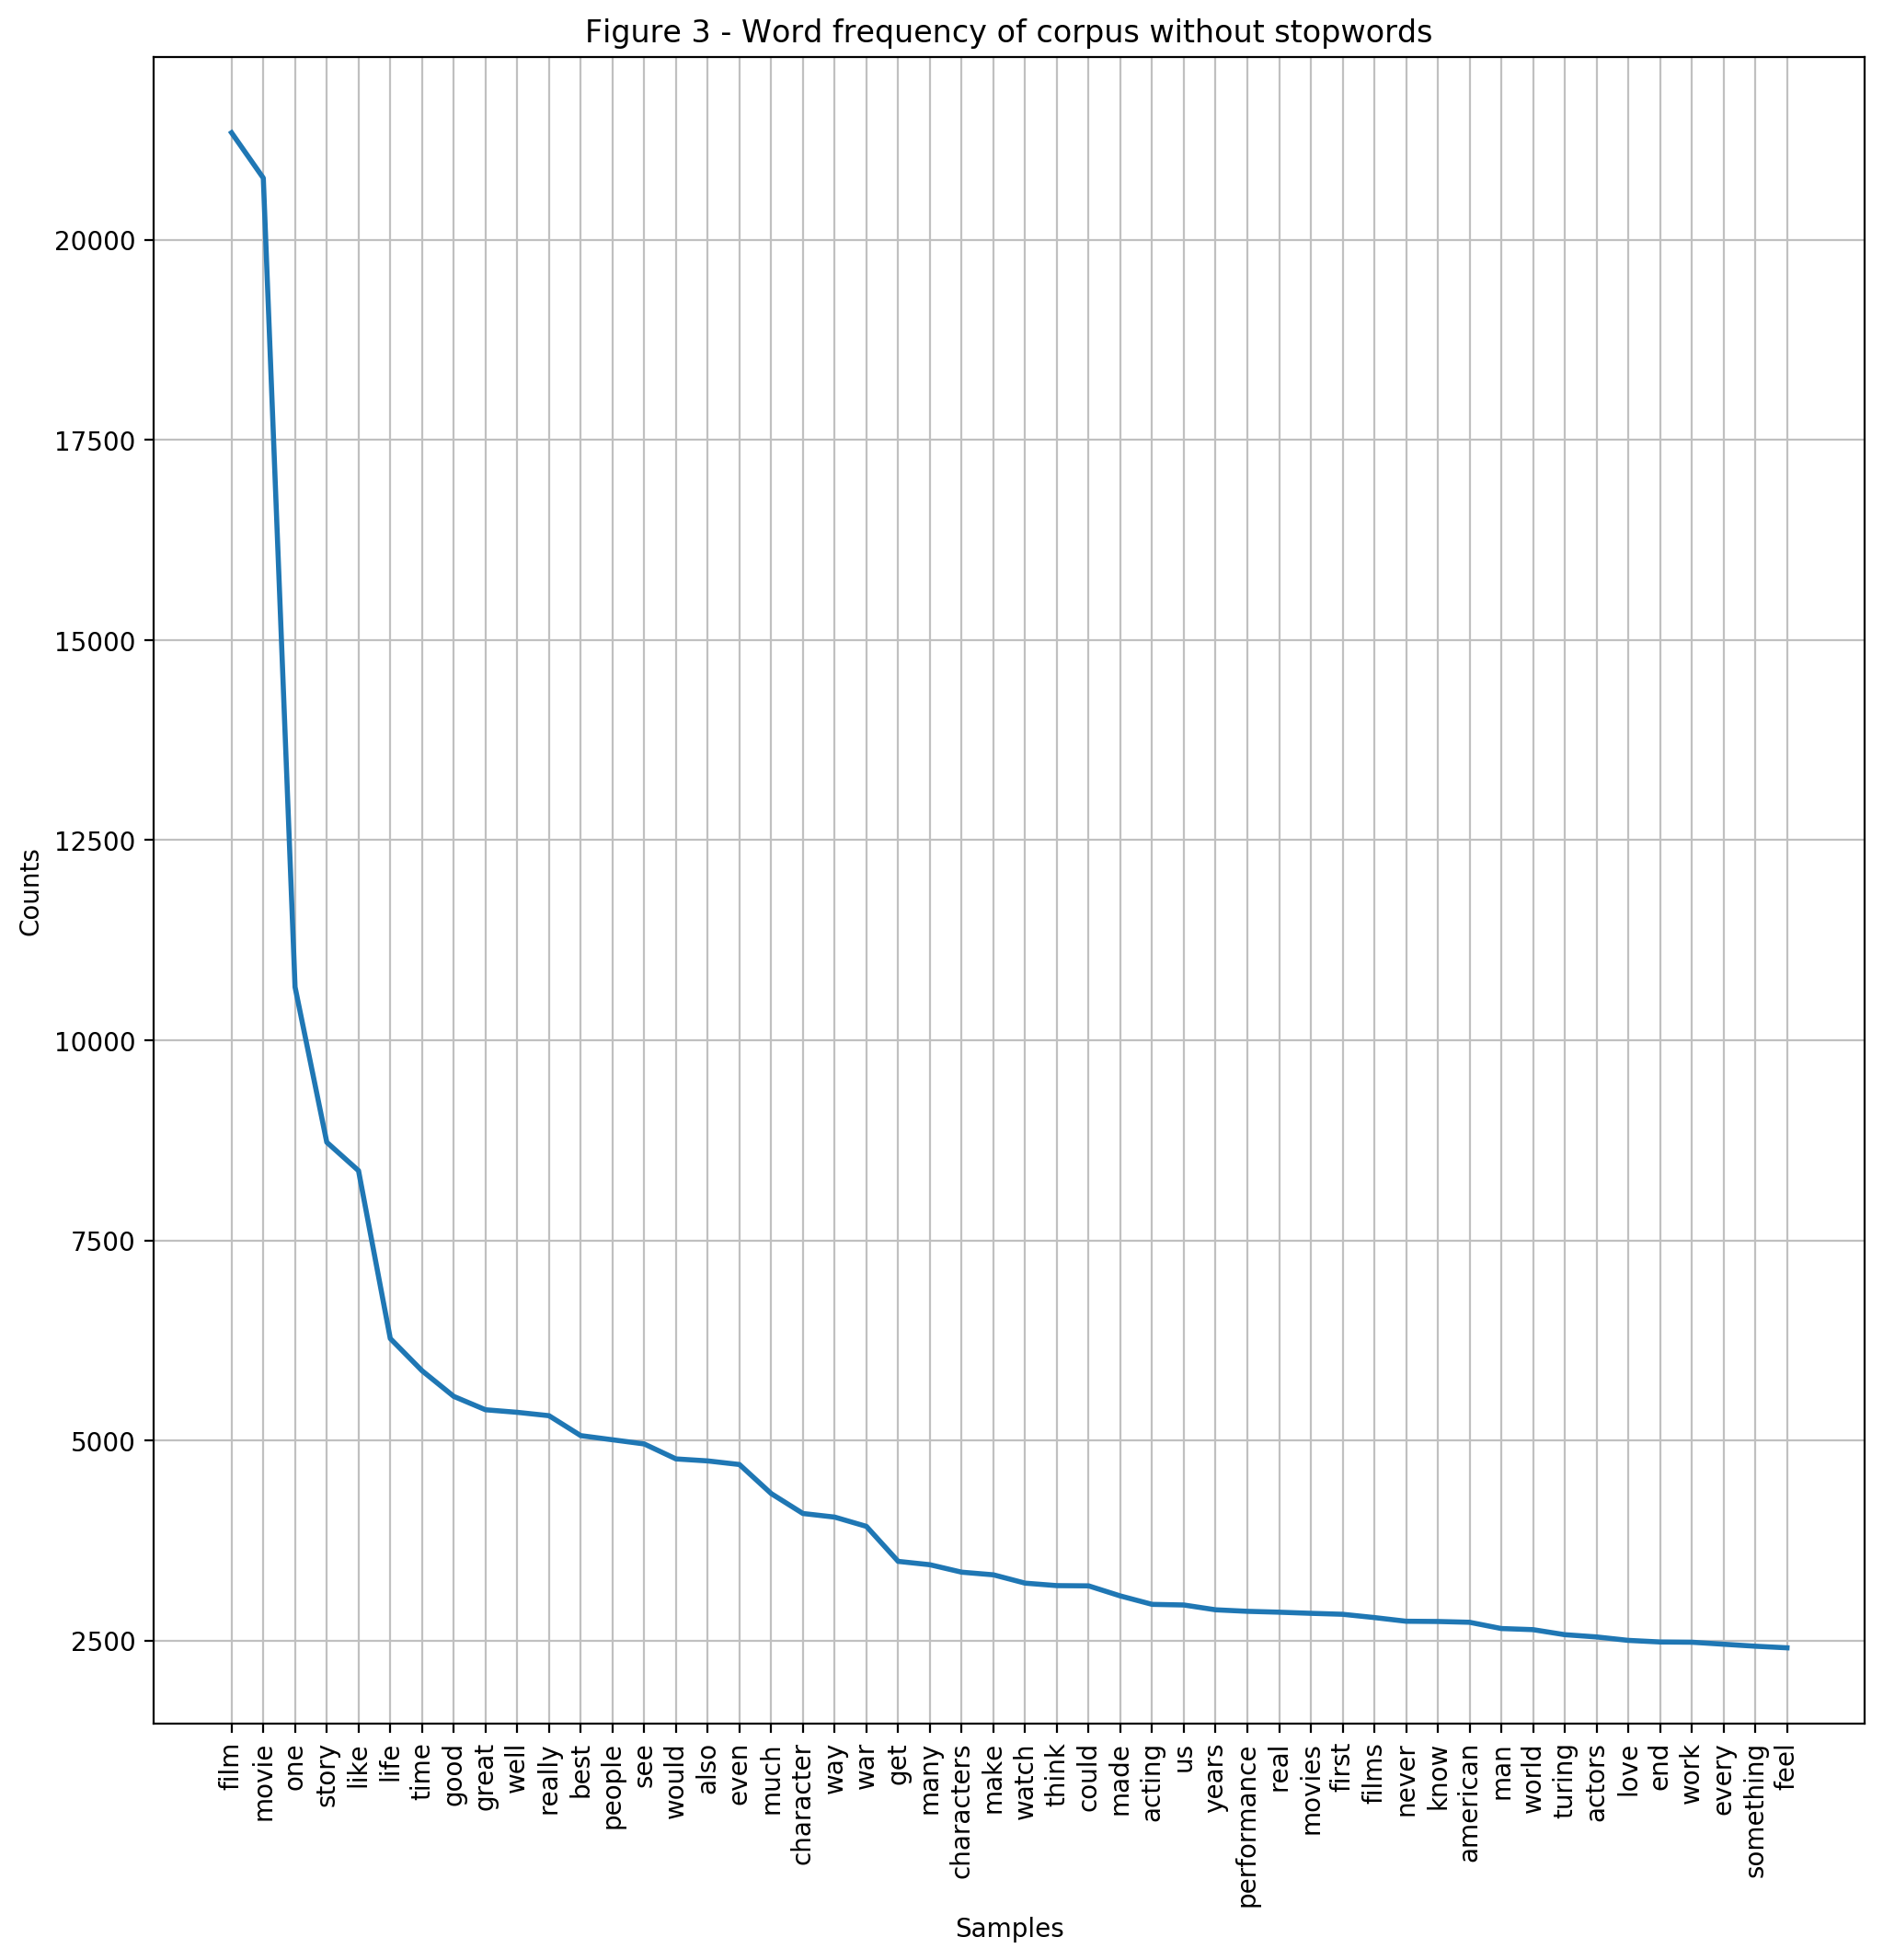

[('film', 21338), ('movie', 20772), ('one', 10666), ('story', 8726), ('like', 8371), ('life', 6274), ('time', 5872), ('good', 5551), ('great', 5384), ('well', 5352), ('really', 5310), ('best', 5061), ('people', 5009), ('see', 4957), ('would', 4770), ('also', 4745), ('even', 4700), ('much', 4337), ('character', 4088), ('way', 4043)]


In [143]:
freqdist = nltk.FreqDist(corpus_no_sw)
freqdist.plot(50, cumulative=False, title='Figure 3 - Word frequency of corpus without stopwords')
#20 most common words
print(freqdist.most_common(20))